<a href="https://colab.research.google.com/github/paulesta55/Notebooks/blob/master/cvaeForTrafficSigns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Variational Autoencoder For Traffic Sign


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cvae">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/cvae.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# to generate gifs
!pip install imageio

## Import TensorFlow and other libraries

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import tensorflow_probability as tfp

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

TensorFlow 2.x selected.


#GTSRDB Loading

GTSRDB train set unziping

In [0]:
!unzip -q "/content/drive/My Drive/datasets/gtsrdb/GTSRB-Training_fixed.zip" 


GTSRDB test set unziping

In [0]:
!unzip -q "/content/drive/My Drive/datasets/gtsrdb/GTSRB_Final_Test_Images.zip" 

In [0]:
def loadTrain(path="/content/GTSRB/Training"):
  data = []
  for subdir in os.walk(os.path.abspath(path)):
    for im in glob.glob(os.path.join(subdir[0],'*.ppm')):
        data.append(np.array(PIL.Image.open(im).resize((16,16))).astype('float32')) #min size for gtsrdb
  return np.array(data).astype('float32')

def loadTest():
  data = []
  for im in glob.glob(os.path.join('/content/GTSRB/Final_Test/Images','*.ppm')):
    data.append(np.array(PIL.Image.open(im).resize((16,16))).astype('float32')) #min size for gtsrdb
  return np.array(data).astype('float32')

In [0]:
train_images = loadTrain()
train_images = train_images.reshape(train_images.shape[0], 16, 16, 3).astype('float32')
test_images = loadTest()
test_images = test_images.reshape(test_images.shape[0], 16, 16, 3).astype('float32')
train_images /= 255.
test_images /= 255.

BATCH_SIZE = 100
TRAIN_BUF = 26640
TEST_BUF = 12630

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 16, 3)


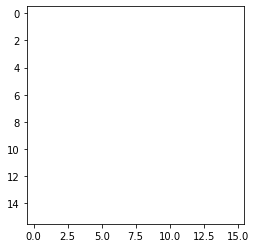

In [0]:
from matplotlib.pyplot import imshow
%matplotlib inline
image = train_set[2]
print(image.shape)
imshow(image)

In [0]:
print(test_images.shape)

(12630, 16, 16, 3)


In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

print(train_dataset) 

<BatchDataset shapes: (None, 16, 16, 3), types: tf.float32>


## Wire up the generative and inference network with *tf.keras.Sequential*

In our VAE example, we use two small ConvNets for the generative and inference network. Since these neural nets are small, we use `tf.keras.Sequential` to simplify our code. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Generative Network
This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. $p(x|z)$. Additionally, we use a unit Gaussian prior $p(z)$ for the latent variable.

### Inference Network
This defines an approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

### Reparameterization Trick
During optimization, we can sample from $q(z|x)$ by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

### Network architecture
For the inference network, we use two convolutional layers followed by a fully-connected layer. In the generative network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

In [0]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(16, 16, 3)),
          tf.keras.layers.Conv2D(
              filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=4*4*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(4, 4, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=3, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    encodes = self.inference_net(x)
    # print("encoding = {0}".format(encodes))
    mean, logvar = tf.split(encodes, num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

In [0]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x):
  # print('x shape = {}'.format(x))
  mean, logvar = model.encode(x)
  # print("logvar = {}".format(logvar))
  # print("mean = {}".format(mean))
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  # print("logpz = {}".format(logpz))
  logqz_x = log_normal_pdf(z, mean, logvar)
  loss = -tf.reduce_mean(logpx_z + logpz - logqz_x)
  return loss

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Training

* We start by iterating over the dataset
* During each iteration, we pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* We then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, we pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$
* **Note:** Since we use the dataset loaded by keras with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST.

## Generate Images

* After training, it is time to generate some images
* We start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$
* Here we plot the probabilities of Bernoulli distributions


In [0]:
epochs = 100
latent_dim = 100
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(np.asarray(predictions[i, :, :, :]))
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

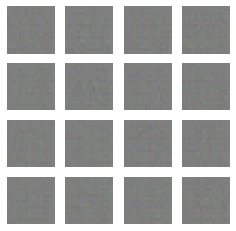

Epoch: 1, Test set ELBO: -446.9169921875, time elapse for current epoch 18.790225982666016


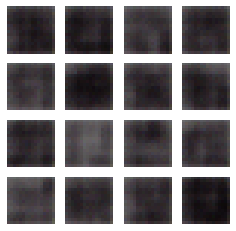

Epoch: 2, Test set ELBO: -433.78466796875, time elapse for current epoch 17.110549926757812


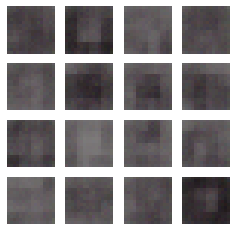

Epoch: 3, Test set ELBO: -428.7585144042969, time elapse for current epoch 17.601202487945557


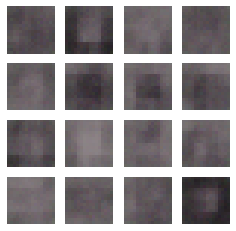

Epoch: 4, Test set ELBO: -422.2535400390625, time elapse for current epoch 17.006073474884033


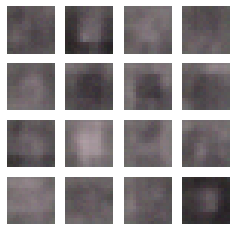

Epoch: 5, Test set ELBO: -417.4812927246094, time elapse for current epoch 16.628827333450317


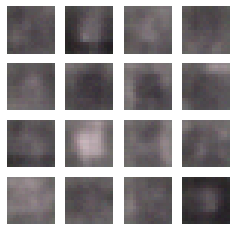

Epoch: 6, Test set ELBO: -415.0950927734375, time elapse for current epoch 16.66291856765747


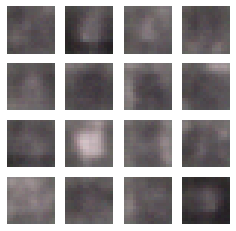

Epoch: 7, Test set ELBO: -413.82342529296875, time elapse for current epoch 16.712740659713745


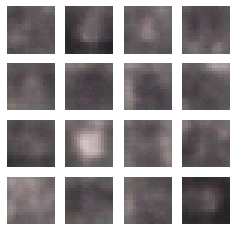

Epoch: 8, Test set ELBO: -412.8469543457031, time elapse for current epoch 17.037488222122192


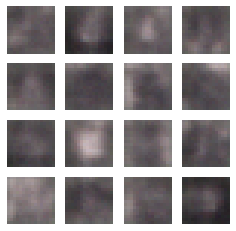

Epoch: 9, Test set ELBO: -411.114501953125, time elapse for current epoch 16.66749334335327


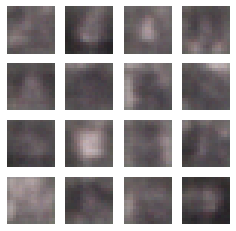

Epoch: 10, Test set ELBO: -410.0741882324219, time elapse for current epoch 16.65677785873413


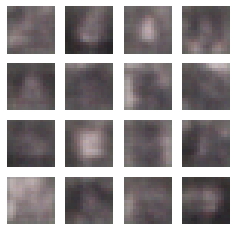

Epoch: 11, Test set ELBO: -408.9043273925781, time elapse for current epoch 16.615936517715454


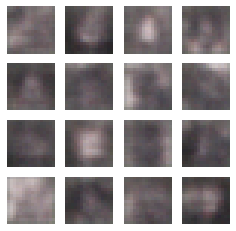

Epoch: 12, Test set ELBO: -407.5521240234375, time elapse for current epoch 16.894237279891968


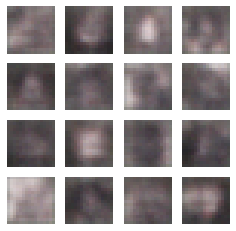

Epoch: 13, Test set ELBO: -406.2340087890625, time elapse for current epoch 16.681458711624146


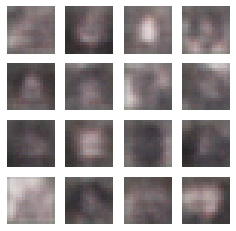

Epoch: 14, Test set ELBO: -405.2987976074219, time elapse for current epoch 16.622073650360107


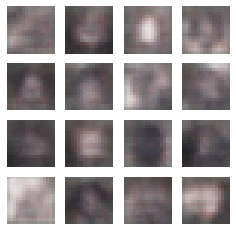

Epoch: 15, Test set ELBO: -404.4664001464844, time elapse for current epoch 16.709033727645874


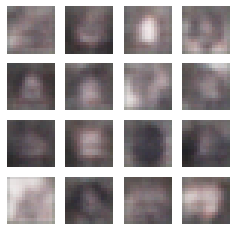

Epoch: 16, Test set ELBO: -403.71099853515625, time elapse for current epoch 17.092008590698242


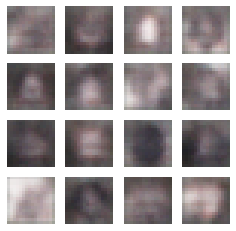

Epoch: 17, Test set ELBO: -403.10546875, time elapse for current epoch 16.75494885444641


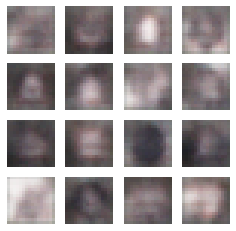

Epoch: 18, Test set ELBO: -402.3121643066406, time elapse for current epoch 16.75069570541382


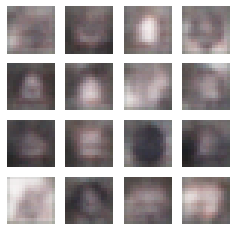

Epoch: 19, Test set ELBO: -402.0751647949219, time elapse for current epoch 16.928399801254272


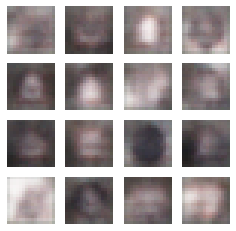

Epoch: 20, Test set ELBO: -401.5813293457031, time elapse for current epoch 17.25740933418274


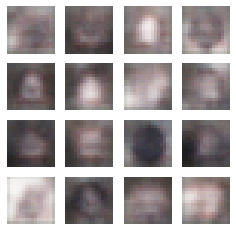

Epoch: 21, Test set ELBO: -401.0126647949219, time elapse for current epoch 16.76294755935669


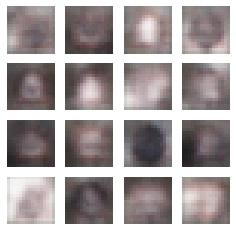

Epoch: 22, Test set ELBO: -400.6726379394531, time elapse for current epoch 16.79349422454834


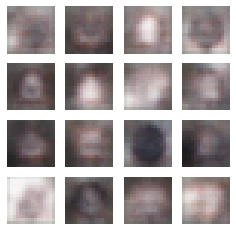

Epoch: 23, Test set ELBO: -400.0130920410156, time elapse for current epoch 17.06315326690674


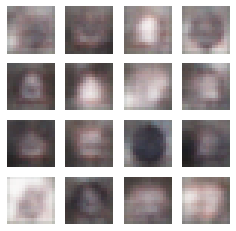

Epoch: 24, Test set ELBO: -399.9844970703125, time elapse for current epoch 17.024760246276855


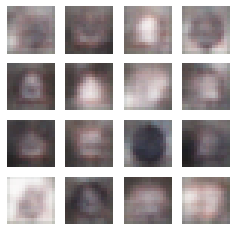

Epoch: 25, Test set ELBO: -399.59588623046875, time elapse for current epoch 16.922319173812866


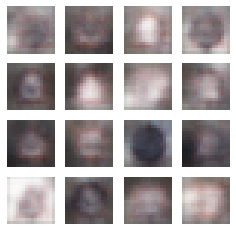

Epoch: 26, Test set ELBO: -399.2980651855469, time elapse for current epoch 16.820541620254517


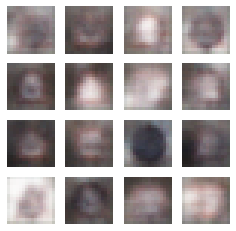

Epoch: 27, Test set ELBO: -399.1957702636719, time elapse for current epoch 16.77354860305786


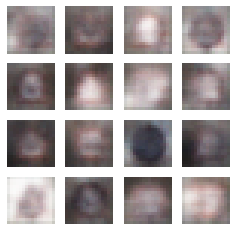

Epoch: 28, Test set ELBO: -399.00341796875, time elapse for current epoch 18.342027187347412


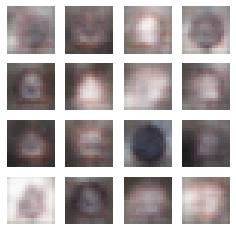

Epoch: 29, Test set ELBO: -398.867431640625, time elapse for current epoch 16.895217180252075


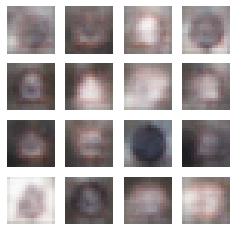

Epoch: 30, Test set ELBO: -398.3544616699219, time elapse for current epoch 16.79009985923767


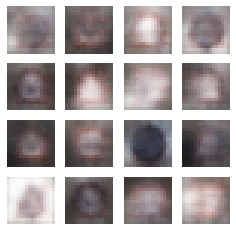

Epoch: 31, Test set ELBO: -398.1806945800781, time elapse for current epoch 16.878157138824463


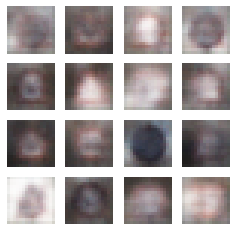

Epoch: 32, Test set ELBO: -398.13470458984375, time elapse for current epoch 17.09993815422058


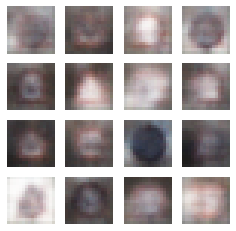

Epoch: 33, Test set ELBO: -397.43316650390625, time elapse for current epoch 16.880979537963867


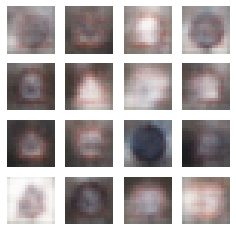

Epoch: 34, Test set ELBO: -397.22235107421875, time elapse for current epoch 17.06070828437805


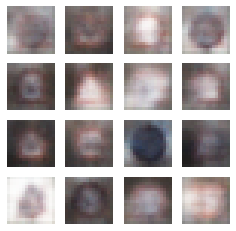

Epoch: 35, Test set ELBO: -397.13873291015625, time elapse for current epoch 16.849273443222046


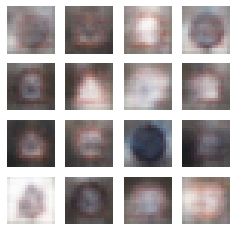

Epoch: 36, Test set ELBO: -396.7023010253906, time elapse for current epoch 17.225314378738403


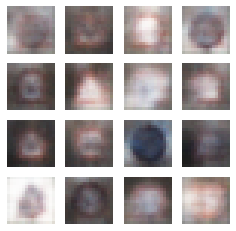

Epoch: 37, Test set ELBO: -396.39727783203125, time elapse for current epoch 16.972639560699463


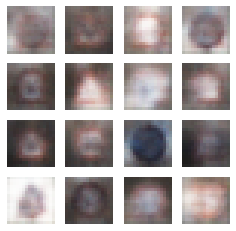

Epoch: 38, Test set ELBO: -396.2757263183594, time elapse for current epoch 17.06111454963684


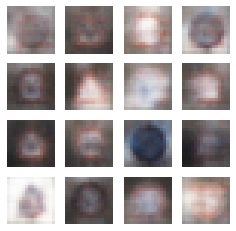

Epoch: 39, Test set ELBO: -395.817626953125, time elapse for current epoch 16.90371346473694


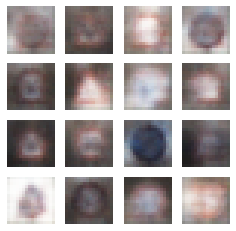

Epoch: 40, Test set ELBO: -395.794677734375, time elapse for current epoch 17.11470675468445


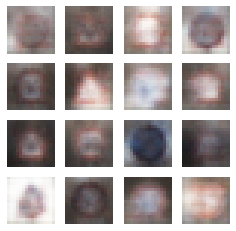

Epoch: 41, Test set ELBO: -395.5276794433594, time elapse for current epoch 16.946896076202393


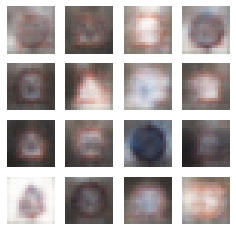

Epoch: 42, Test set ELBO: -395.3330993652344, time elapse for current epoch 16.884102821350098


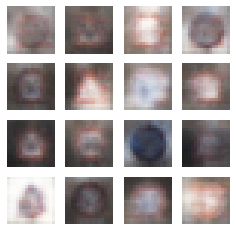

Epoch: 43, Test set ELBO: -395.2384948730469, time elapse for current epoch 16.90752625465393


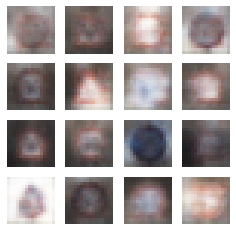

Epoch: 44, Test set ELBO: -395.0531005859375, time elapse for current epoch 17.16123676300049


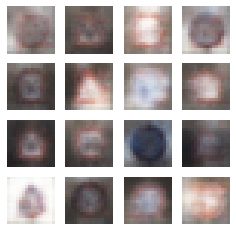

Epoch: 45, Test set ELBO: -394.90509033203125, time elapse for current epoch 16.927516222000122


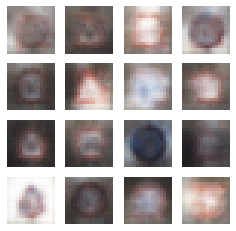

Epoch: 46, Test set ELBO: -394.65814208984375, time elapse for current epoch 16.839882850646973


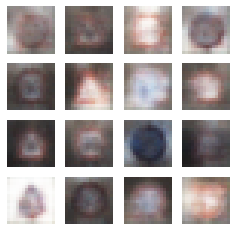

Epoch: 47, Test set ELBO: -394.56817626953125, time elapse for current epoch 16.917035579681396


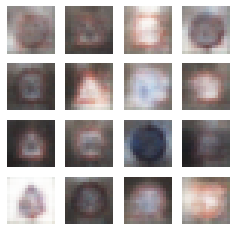

Epoch: 48, Test set ELBO: -394.4248962402344, time elapse for current epoch 17.205641984939575


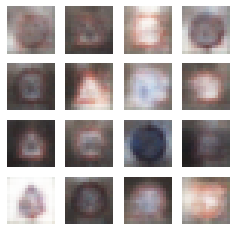

Epoch: 49, Test set ELBO: -394.3701477050781, time elapse for current epoch 17.103168725967407


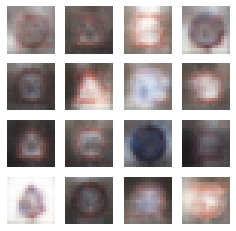

Epoch: 50, Test set ELBO: -394.30633544921875, time elapse for current epoch 16.809687852859497


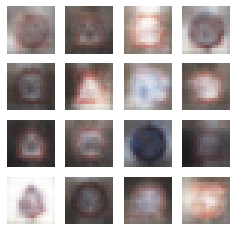

Epoch: 51, Test set ELBO: -394.1682434082031, time elapse for current epoch 17.061989307403564


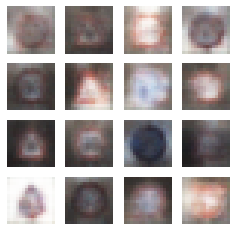

Epoch: 52, Test set ELBO: -394.0436706542969, time elapse for current epoch 17.433090686798096


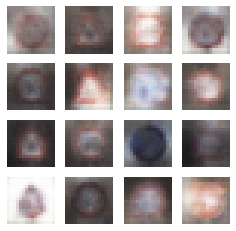

Epoch: 53, Test set ELBO: -393.8796691894531, time elapse for current epoch 17.111417770385742


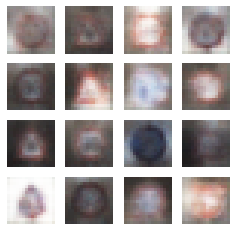

Epoch: 54, Test set ELBO: -393.9013977050781, time elapse for current epoch 16.99074387550354


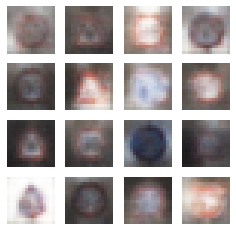

Epoch: 55, Test set ELBO: -393.7168273925781, time elapse for current epoch 16.9065101146698


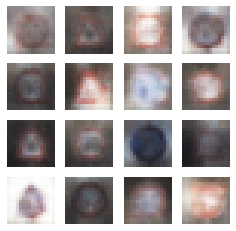

Epoch: 56, Test set ELBO: -393.8810119628906, time elapse for current epoch 16.7661714553833


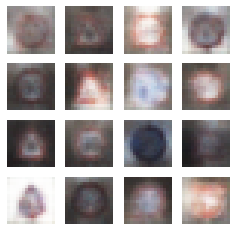

Epoch: 57, Test set ELBO: -393.80401611328125, time elapse for current epoch 16.65900683403015


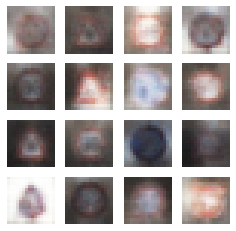

Epoch: 58, Test set ELBO: -393.459228515625, time elapse for current epoch 16.791333436965942


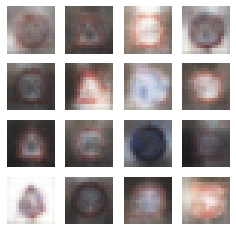

Epoch: 59, Test set ELBO: -393.5003356933594, time elapse for current epoch 16.878549337387085


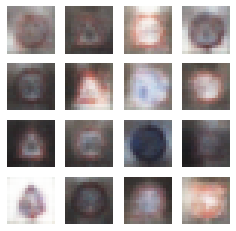

Epoch: 60, Test set ELBO: -393.0705871582031, time elapse for current epoch 17.23739194869995


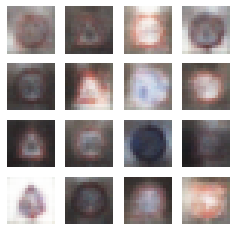

Epoch: 61, Test set ELBO: -393.1382751464844, time elapse for current epoch 16.89342451095581


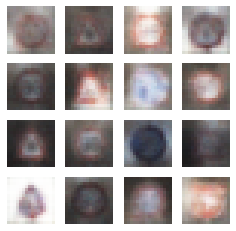

Epoch: 62, Test set ELBO: -393.1327819824219, time elapse for current epoch 16.94219422340393


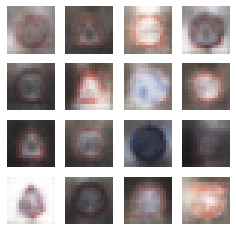

Epoch: 63, Test set ELBO: -393.0920104980469, time elapse for current epoch 17.070927381515503


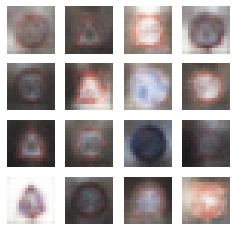

Epoch: 64, Test set ELBO: -392.8564758300781, time elapse for current epoch 17.325161695480347


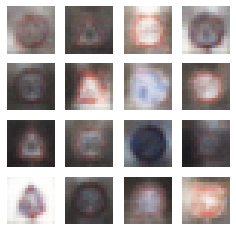

Epoch: 65, Test set ELBO: -392.8620910644531, time elapse for current epoch 16.867523431777954


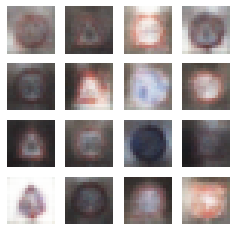

Epoch: 66, Test set ELBO: -392.8447265625, time elapse for current epoch 16.846713304519653


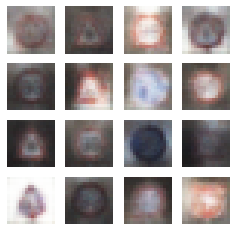

Epoch: 67, Test set ELBO: -392.7708435058594, time elapse for current epoch 17.22410821914673


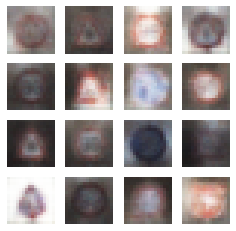

Epoch: 68, Test set ELBO: -392.5618591308594, time elapse for current epoch 17.14720392227173


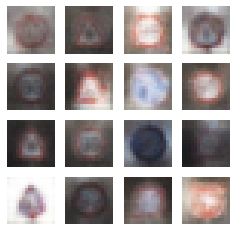

Epoch: 69, Test set ELBO: -392.659423828125, time elapse for current epoch 17.111264944076538


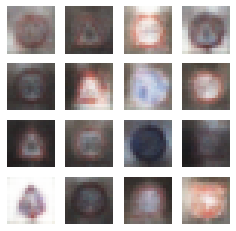

Epoch: 70, Test set ELBO: -392.6806640625, time elapse for current epoch 16.943049430847168


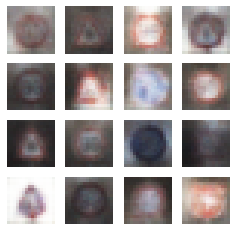

Epoch: 71, Test set ELBO: -392.86614990234375, time elapse for current epoch 16.742701053619385


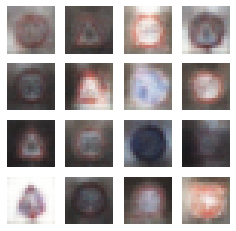

Epoch: 72, Test set ELBO: -392.28485107421875, time elapse for current epoch 17.08711814880371


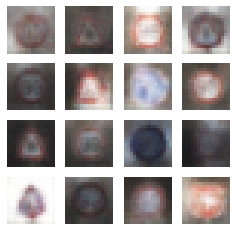

Epoch: 73, Test set ELBO: -392.61785888671875, time elapse for current epoch 16.445666790008545


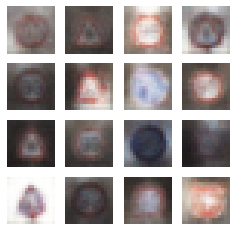

Epoch: 74, Test set ELBO: -392.4493103027344, time elapse for current epoch 16.564879894256592


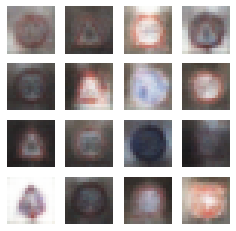

Epoch: 75, Test set ELBO: -392.2378234863281, time elapse for current epoch 16.530966997146606


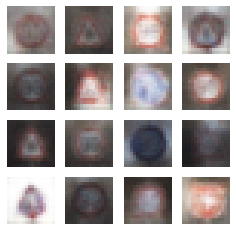

Epoch: 76, Test set ELBO: -392.3628845214844, time elapse for current epoch 17.16187882423401


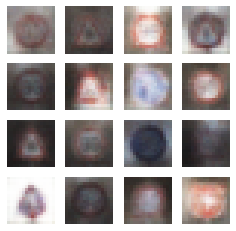

Epoch: 77, Test set ELBO: -392.3935546875, time elapse for current epoch 16.43376088142395


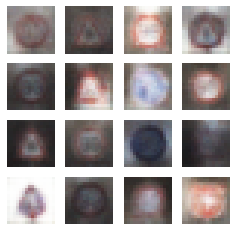

Epoch: 78, Test set ELBO: -392.3351135253906, time elapse for current epoch 16.531787633895874


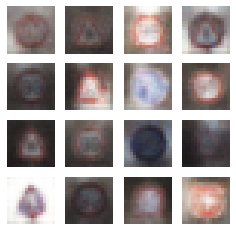

Epoch: 79, Test set ELBO: -392.2955627441406, time elapse for current epoch 16.508934497833252


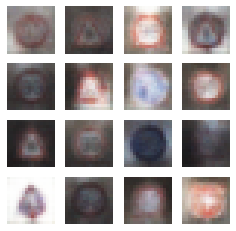

Epoch: 80, Test set ELBO: -391.9739074707031, time elapse for current epoch 16.63837480545044


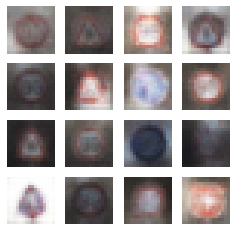

Epoch: 81, Test set ELBO: -391.9605407714844, time elapse for current epoch 16.763766527175903


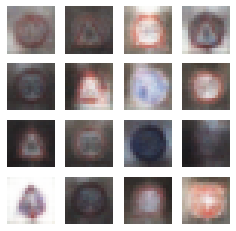

Epoch: 82, Test set ELBO: -391.8816223144531, time elapse for current epoch 16.402607440948486


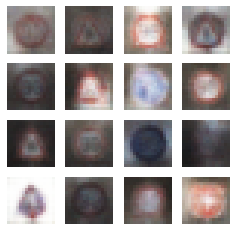

Epoch: 83, Test set ELBO: -391.9470520019531, time elapse for current epoch 16.42394185066223


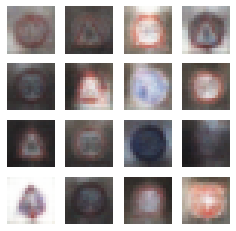

Epoch: 84, Test set ELBO: -391.95489501953125, time elapse for current epoch 16.900694847106934


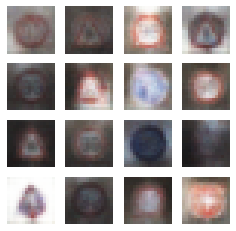

Epoch: 85, Test set ELBO: -391.80389404296875, time elapse for current epoch 16.82687544822693


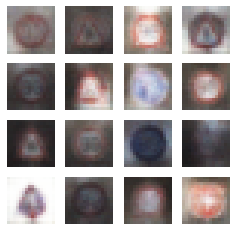

Epoch: 86, Test set ELBO: -391.7003479003906, time elapse for current epoch 16.3854558467865


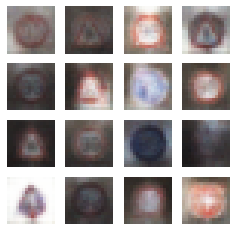

Epoch: 87, Test set ELBO: -391.55523681640625, time elapse for current epoch 16.479753255844116


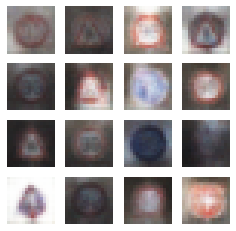

Epoch: 88, Test set ELBO: -391.82415771484375, time elapse for current epoch 16.645886421203613


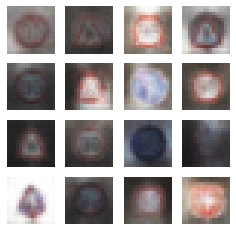

Epoch: 89, Test set ELBO: -391.5585021972656, time elapse for current epoch 16.522127389907837


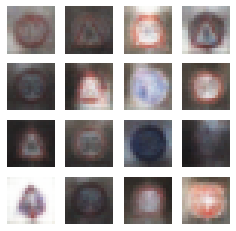

Epoch: 90, Test set ELBO: -391.5776672363281, time elapse for current epoch 16.546977758407593


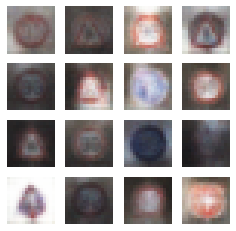

Epoch: 91, Test set ELBO: -391.4627380371094, time elapse for current epoch 16.39431095123291


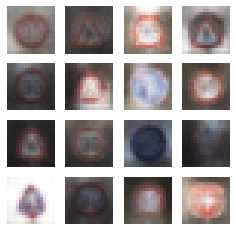

Epoch: 92, Test set ELBO: -391.3052673339844, time elapse for current epoch 16.78317093849182


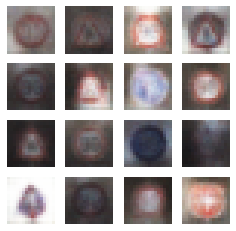

Epoch: 93, Test set ELBO: -391.5326232910156, time elapse for current epoch 16.50586223602295


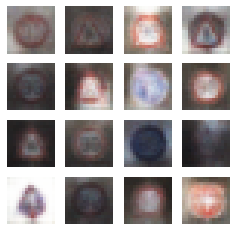

Epoch: 94, Test set ELBO: -391.3548278808594, time elapse for current epoch 16.915218591690063


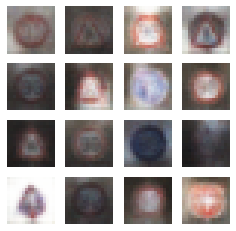

Epoch: 95, Test set ELBO: -391.350830078125, time elapse for current epoch 16.55928134918213


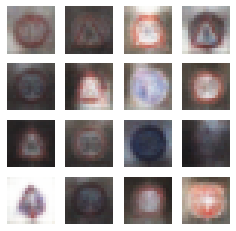

Epoch: 96, Test set ELBO: -391.3529052734375, time elapse for current epoch 16.79935121536255


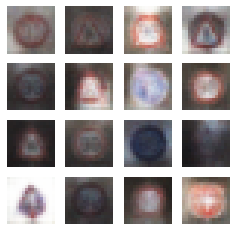

Epoch: 97, Test set ELBO: -391.2171936035156, time elapse for current epoch 16.529139280319214


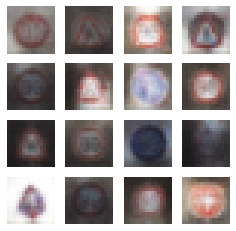

Epoch: 98, Test set ELBO: -391.3345947265625, time elapse for current epoch 16.92976951599121


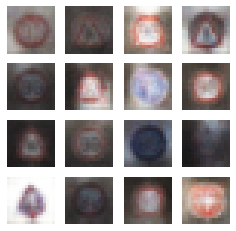

Epoch: 99, Test set ELBO: -391.2615051269531, time elapse for current epoch 16.471386671066284


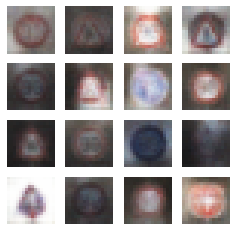

Epoch: 100, Test set ELBO: -390.9508361816406, time elapse for current epoch 17.569168090820312


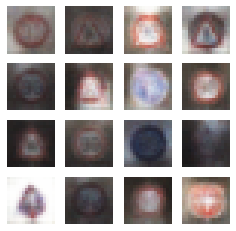

In [0]:
# tf.config.experimental_run_functions_eagerly(True)
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x))
      
    elbo = -loss.result()
    
    # display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                  end_time - start_time))
    generate_and_save_images(
        model, epoch, random_vector_for_generation)

### Display an image using the epoch number

In [0]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

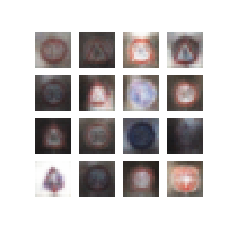

In [0]:
plt.imshow(display_image(epochs))
plt.axis('off')# Display images

### Generate a GIF of all the saved images.

In [0]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
  display.Image(filename=anim_file)

If you're working in Colab you can download the animation with the code below:

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)